# **IDEB**

A atividade consiste em executar modelos de machine learning para prever as notas do IDEB de cada município brasileiro.

As notas do IDEB para cada município estão disponíveis na plataforma BASE DOS DADOS.

Utilize a query SELECT * FROM `basedosdados.br_inep_ideb.municipio`.

Selecione apenas as variáveis: rede, ensino, anos_escolares, taxa_aprovacao, indicador_rendimento, nota_saeb_matematica, nota_saeb_lingua_portuguesa, ideb. NÃO LIMITE A QUANTIDADE DE REGISTROS.

### Importando as bibliotecas 

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor

from google.cloud import bigquery
from google.oauth2 import service_account

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Credencial de acesso ao bigquery

#credential = service_account.Credentials.from_service_account_file('')

credencial = service_account.Credentials.from_service_account_file(
    '/content/marcella-sirius-2d62166debee.json')

client = bigquery.Client(credentials=credencial, project=credencial.project_id)

### Lendo o conjunto de dados

In [3]:
# Insira aqui a query para filtrar os dados

df = client.query('''SELECT 
                    rede, 
                    ensino, 
                    anos_escolares, 
                    taxa_aprovacao, 
                    indicador_rendimento, 
                    nota_saeb_matematica, 
                    nota_saeb_lingua_portuguesa, 
                    ideb  
                    FROM `basedosdados.br_inep_ideb.municipio`''').to_dataframe()
df.head()


,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
0,municipal,fundamental,iniciais (1-5),53.9,0.561795,167.8,165.60,2.3
1,estadual,fundamental,iniciais (1-5),49.3,0.501470,151.8,149.60,1.8
2,municipal,fundamental,iniciais (1-5),48.8,0.494267,163.6,155.80,1.9
3,publica,fundamental,iniciais (1-5),48.8,0.497858,159.0,153.39,1.9
4,municipal,fundamental,iniciais (1-5),74.7,0.752579,138.0,134.19,2.3


### Verifique a dimensão do conjunto de dados

In [4]:
# Verifique a dimensão do conjunto de dados
df.shape

(294426, 8)

### Verifique os tipos de dados

In [5]:
# Verifique os tipos de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294426 entries, 0 to 294425
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   rede                         294426 non-null  object 
 1   ensino                       294426 non-null  object 
 2   anos_escolares               294426 non-null  object 
 3   taxa_aprovacao               230833 non-null  float64
 4   indicador_rendimento         230823 non-null  float64
 5   nota_saeb_matematica         197870 non-null  float64
 6   nota_saeb_lingua_portuguesa  197870 non-null  float64
 7   ideb                         222045 non-null  float64
dtypes: float64(5), object(3)
memory usage: 18.0+ MB


In [6]:
df[['rede',	'ensino',	'anos_escolares']].value_counts()

rede       ensino       anos_escolares
publica    fundamental  finais (6-9)      50112
                        iniciais (1-5)    50076
municipal  fundamental  iniciais (1-5)    48654
estadual   fundamental  finais (6-9)      44100
municipal  fundamental  finais (6-9)      34947
estadual   fundamental  iniciais (1-5)    31329
publica    medio        todos (1-4)       16635
estadual   medio        todos (1-4)       16629
federal    medio        todos (1-4)        1314
municipal  medio        todos (1-4)         297
federal    fundamental  finais (6-9)        198
                        iniciais (1-5)      135
dtype: int64

        As variáveis categóricas são de quais tipos (Nominal ou Ordinal)?
rede - nominal 

ensino e anos_escolares - ordinal 
        

### Verifique dados duplicados

In [7]:
# Dados duplicados

df.duplicated().sum()

65067

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Verifique os valores ausentes

In [9]:
# Verifique dados ausentes
df.isnull().sum()

rede                               0
ensino                             0
anos_escolares                     0
taxa_aprovacao                    40
indicador_rendimento              47
nota_saeb_matematica           31489
nota_saeb_lingua_portuguesa    31489
ideb                            7993
dtype: int64

        Existe valores ausentes? Como você irá tratar?

        Sim, excluir 


In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

rede                           0
ensino                         0
anos_escolares                 0
taxa_aprovacao                 0
indicador_rendimento           0
nota_saeb_matematica           0
nota_saeb_lingua_portuguesa    0
ideb                           0
dtype: int64

### Correlação

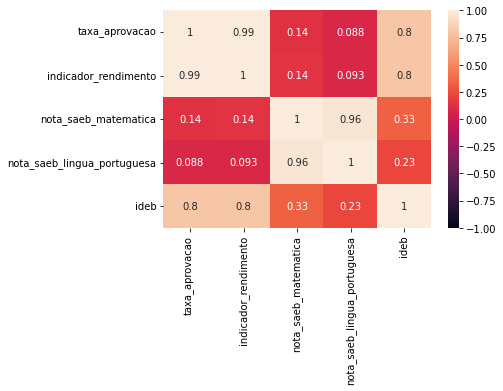

In [12]:
# Correlação

sns.heatmap(df.corr(), vmin=-1, vmax=1,  annot=True)

        Quais insights podemos obter ao analisar a correlação das variáveis?

        Correlação entre ideb e taxa_aprovacao
        Correlação entre ideb e indicador_rendimento

## Pré-processamento

### Tratando valores ausentes

In [13]:
# Tratando valores ausentes


# Já tratados 

### Separe as variáveis independentes (variáveis preditoras) da variável dependente (variável alvo) 

Por exemplo:

X = variáveis independentes

y = variavel dependente

In [14]:
# Separando as variáveis

X = df.drop('ideb', axis=1)
y = df['ideb']

### Separe os dados em conjunto de treinamento e conjunto de teste

Separe os dados com 70% para treino e 30% para teste

In [34]:
# Separe os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


In [35]:
X_train.shape, X_test.shape

((138487, 7), (59352, 7))

### Codifique as variáveis categóricas

A codificação de variáveis categóricas (formato texto) é um passo de suma importância para os modelos de machine learning, pois os modelos só pode interpretar dados númericos.

In [36]:
# Utilize o método select_dtypes() para obter a lista de variáveis categóricas

# Observação: Utilize o conjunto de treinamento

X_train.select_dtypes(include= 'object').columns


Index(['rede', 'ensino', 'anos_escolares'], dtype='object')

In [37]:
# Codificando as variáveis CATEGÓRICAS NOMINAIS
# O OneHotEncoder é um transformador utilizado para codificar variáveis categóricas nominais.
# Instânciando o OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Transforme as variáveis categóricas do conjunto de treino (use fit_transform() para treino - Dúvidas consulte a documentação)

## df_train_nominal = pd.DataFrame(encoder.fit_transform(X_train['rede'].values.reshape(-1, 1)))
## df_train_nominal.columns = encoder.get_feature_names(['rede'])
df_train_nominal = encoder.fit_transform(X_train['rede'].values.reshape(-1, 1))

# Transforme as variáveis categóricas do conjunto de teste (use transform para teste - Dúvidas consulte a documentação)

## df_test_nominal = pd.DataFrame(encoder.fit_transform(X_test['rede'].values.reshape(-1, 1)))
## df_test_nominal.columns = encoder.get_feature_names(['rede'])
df_test_nominal = encoder.fit_transform(X_test['rede'].values.reshape(-1, 1))

In [38]:
# Codificando as variáveis CATEGÓRICAS ORDINAIS
# O OrdinalEncoder é um transformador utilizado para codificar variáveis categóricas ordinais.
enc = OrdinalEncoder(categories= [
                                 ['fundamental', 'medio'],
                                 ['iniciais (1-5)', 'finais (6-9)', 'todos (1-4)']
                                 ])

# Transforme as variáveis categóricas do conjunto de treino (use fit_transform() para treino - Dúvidas consulte a documentação)

## df_train_ordinal = pd.DataFrame(enc.fit_transform(X_train[['ensino', 'anos_escolares']]))
df_train_ordinal = enc.fit_transform(X_train[['ensino', 'anos_escolares']])

# Transforme as variáveis categóricas do conjunto de teste (use transform para teste - Dúvidas consulte a documentação)

## df_test_ordinal = pd.DataFrame(enc.fit_transform(X_test[['ensino', 'anos_escolares']]
df_test_ordinal = enc.fit_transform(X_test[['ensino', 'anos_escolares']])

In [39]:
# Excluir as variáveis categóricas do conjunto de treino

X_train.drop(['rede','ensino', 'anos_escolares'] ,axis=1, inplace=True)

# Excluir as variáveis categóricas do conjunto de teste

X_test.drop(['rede','ensino', 'anos_escolares'] ,axis=1, inplace=True)

In [40]:
# Inserir as variáveis categóricas transformadas no conjunto de treino

## df_train = pd.concat([X_train, df_train_nominal, df_train_ordinal], axis=1)
X_train[encoder.get_feature_names_out()] = df_train_nominal
X_train[['ensino', 'anos_escolares']] = df_train_ordinal

# Inserir as variáveis categóricas transformadas no conjunto de teste

## df_test = pd.concat([X_test, df_test_nominal,df_test_ordinal], axis=1)
X_test[encoder.get_feature_names_out()] = df_test_nominal
X_test[['ensino', 'anos_escolares']] = df_test_ordinal


In [22]:
X_train.shape, X_test.shape

((138487, 10), (59352, 10))

In [23]:
X_train.isnull().sum()

taxa_aprovacao                 0
indicador_rendimento           0
nota_saeb_matematica           0
nota_saeb_lingua_portuguesa    0
x0_estadual                    0
x0_federal                     0
x0_municipal                   0
x0_publica                     0
ensino                         0
anos_escolares                 0
dtype: int64

In [24]:
X_test.isnull().sum()

taxa_aprovacao                 0
indicador_rendimento           0
nota_saeb_matematica           0
nota_saeb_lingua_portuguesa    0
x0_estadual                    0
x0_federal                     0
x0_municipal                   0
x0_publica                     0
ensino                         0
anos_escolares                 0
dtype: int64

### Normalizar ou Padronizar os dados

A padronização de um conjunto de dados é um requisito comum para muitos estimadores/modelos de aprendizado de máquina: eles podem se comportar mal se os recursos individuais não se parecerem mais ou menos com dados padrão normalmente distribuídos (por exemplo, Gaussiano com média 0 e variância de unidade).

A padronização é necessária quando os valores das variáveis numéricas estão em escalas diferentes. Se uma variável tem uma variância que é ordens de magnitude maior do que outros, ela pode dominar a função objetivo e tornar o modelo incapaz de aprender com outras variáveis corretamente como esperado.

In [25]:
# O StandardScaler padroniza variáveis removendo a média e dimensionando para a variação da unidade.
from sklearn.preprocessing import StandardScaler

# Instanciando o StandardScaler
scaler = StandardScaler()


# Padronizando os dados do conjunto de treino (use fit_transform() para treino - Dúvidas consulte a documentação)
X_train = scaler.fit_transform(X_train)


# Padronizando os dados do conjunto de teste (use transform() para teste - Dúvidas consulte a documentação)
X_test = scaler.transform(X_test)

## Modelos de Machine Learning

In [26]:
def metricas (y_, y_pred):
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error as MAE
  from sklearn.metrics import r2_score
  MSE = mean_squared_error(y_, y_pred)
  RMSE = mean_squared_error(y_, y_pred, squared=False)
  MAE = MAE(y_, y_pred)
  r2 = r2_score(y_, y_pred)
  print(f'MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, R2: {r2}')

### Linear Regression

In [27]:
# Instanciando o modelo
from sklearn.linear_model import LinearRegression
modeloLR = LinearRegression()

# Treinando o modelo
modeloLR.fit(X_train, y_train)

# Fazendo as predições para o conjunto de treino e teste
predicao_modeloLR_train = modeloLR.predict(X_train)
predicao_modeloLR_test = modeloLR.predict(X_test)

# Avaliando os modelos com as métricas R2, MSE e MAE
metricas(y_train,predicao_modeloLR_train)
metricas(y_test,predicao_modeloLR_test)

MSE: 0.01365469979184125, RMSE: 0.11685332597680415, MAE: 0.08709412171129931, R2: 0.9891773391469572
MSE: 0.013968520781291781, RMSE: 0.11818849682304865, MAE: 0.08779908347444007, R2: 0.9889733304062535


### Decision Tree Regressor

In [28]:
# Instanciando o modelo
from sklearn.tree import DecisionTreeRegressor
modeloDT = DecisionTreeRegressor()

# Treinando o modelo
modeloDT.fit(X_train, y_train)

# Fazendo as predições para o conjunto de treino e teste
predicao_modeloDT_train = modeloDT.predict(X_train)
predicao_modeloDT_test = modeloDT.predict(X_test)

# Avaliando os modelos com as métricas R2, MSE e MAE
metricas(y_train,predicao_modeloDT_train)
metricas(y_test,predicao_modeloDT_test)

MSE: 8.737354962497226e-31, RMSE: 9.347381966356796e-16, MAE: 4.677836733851389e-16, R2: 1.0
MSE: 0.0025535786494136673, RMSE: 0.050532946177851805, MAE: 0.019749966302736593, R2: 0.9979842197688934


### Random Forest Regressor

In [29]:
# Instanciando o modelo
from sklearn.ensemble import RandomForestRegressor
modeloRF = RandomForestRegressor(n_estimators=100, min_samples_leaf =2)

# Treinando o modelo
modeloRF.fit(X_train, y_train)

# Fazendo as predições para o conjunto de treino e teste
predicao_modeloRF_train = modeloRF.predict(X_train)
predicao_modeloRF_test = modeloRF.predict(X_test)

# Avaliando os modelos com as métricas R2, MSE e MAE
metricas(y_train,predicao_modeloRF_train)
metricas(y_test,predicao_modeloRF_test)

MSE: 0.00033572535119132807, RMSE: 0.018322809587815077, MAE: 0.011160026368523791, R2: 0.9997339054192986
MSE: 0.0013065051044796802, RMSE: 0.03614560975387855, MAE: 0.022167562069946602, R2: 0.9989686524195937


### XGBoost

In [30]:
# Instanciando o modelo
from xgboost import XGBRegressor
modeloXGB = XGBRegressor()

# Treinando o modelo
modeloXGB.fit(X_train,y_train)

# Fazendo as predições para o conjunto de treino e teste
predicao_modeloXGB_train = modeloXGB.predict(X_train)
predicao_modeloXGB_test = modeloXGB.predict(X_test)

# Avaliando os modelos com as métricas R2, MSE e MAE
metricas(y_train,predicao_modeloXGB_train)
metricas(y_test,predicao_modeloXGB_test)

[02:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 0.008496993697483208, RMSE: 0.09217913916653381, MAE: 0.06883618220967426, R2: 0.9932653165239671
MSE: 0.0087508355844552, RMSE: 0.09354590094950821, MAE: 0.0696494168662562, R2: 0.993092140952518


### **Considerando as informações acima, os modelos apresentaram overfitting ou underfitting**?



### **Qual o melhor modelo para prever notas do IDEB?**

